This notebook contains the discovery for how to calculate the CPT for P(O2 Saturation Fully Functional Alveoli | Healthy O2 Saturation, Airway Resistance)

In [1]:
import numpy as np
import sys

sys.path.append("../milestone_model")
import lung_health_models

# Import import model_helpers as mh
sys.path.append("../model_helpers")
import model_helpers as mh

In [2]:
# How to use reshape to convert a 3D CPT to a 2D that can be ingested by PGMPY?

CPT_i_j_k = np.array(
    [[[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]], [[0.7, 0.8, 0.9], [0.11, 0.12, 0.13]]]
)
CPT_i_j_k.shape
# Reshape to 2D
CPT_i_j_k.reshape(2, 6)

array([[0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 ],
       [0.7 , 0.8 , 0.9 , 0.11, 0.12, 0.13]])

In [2]:
healthy_FEV1_prior = {
    "type": "gaussian",
    "mu": 3.5,
    "sigma": 0.4,
}
healthy_o2sat_prior = {
    "type": "gaussian",
    "mu": 0.98,
    "sigma": 0.01,
}
(
    model,
    HFEV1,
    prior_hfev1,
    FEV1,
    HO2Sat,
    prior_ho2sat,
    O2SatFFA,
    AR,
    prior_ar,
) = lung_health_models.build_FEV1_O2_point_in_time_model(
    healthy_FEV1_prior, healthy_o2sat_prior
)

*** Building lung model with HFEV1 and AB ***
Defining gaussian prior with mu = 3.50, sigma = 0.4
Defining gaussian prior with mu = 0.98, sigma = 0.01


/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/O2_modelling/../milestone_model/model_helpers.py:289: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, abserr = integrate.quad(


In [4]:
HO2Sat.bins

array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ,
       0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [106]:
O2SatFFA.bins.shape

(31,)

In [6]:
AR.bins

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 ])

In [3]:
def get_intersecting_bins_idx(intersecting_bin, bin_list, debug=False):
    """
    Returns the indices of the bins in bin_list that intersect with bin
    Assumes that the bins are sorted in increasing order and with same bin_width
    """
    bin_list_width = bin_list[1] - bin_list[0]
    # Width of intersecting bin can't be 0
    if intersecting_bin[1] - intersecting_bin[0] == 0:
        raise ValueError("Intersecting bin width should be non-zero")

    # Checks that the bin falls strictly within the range [bin_list[0]; bin_list[-1]]
    overlap_error = ValueError(
        f"Shifted X bin {intersecting_bin} intersects none of the Z bins {bin_list}"
    )
    if intersecting_bin[1] < bin_list[0]:
        raise overlap_error
    # Raise if X_shifted_bin_low is larger than the largest Z bin
    if intersecting_bin[0] >= bin_list[-1] + bin_list_width:
        raise overlap_error
    left_away_error = ValueError("A portion of the shifted X bin is outside the Z bins")
    if intersecting_bin[0] < bin_list[0]:
        raise left_away_error
    if intersecting_bin[1] > bin_list[-1] + bin_list_width:
        raise left_away_error

    idx1, idxn = np.searchsorted(bin_list, [intersecting_bin[0], intersecting_bin[1]])
    if debug:
        print("Idx from searchsorted func", idx1, ",", idxn)

    k1 = idx1 - 1
    if idx1 <= len(bin_list) - 1 and bin_list[idx1] == intersecting_bin[0]:
        k1 = idx1

    kn = idxn - 1

    if debug:
        print(
            "Bins idx",
            k1,
            ",",
            kn,
            "corresponding to values",
            bin_list[k1],
            bin_list[kn],
        )
    return (k1, kn)


def get_bin_contribution_to_cpt(shifted_X_bin, Z_bins, debug=False, tol=1e-6):
    """
    Returns a vector of probabilities representing the contribution of the shifted X bin to a set of Z_bins (i.e. cpt[:, i, j])

    Each element in Z_bins correspond to the interval [Z_bins[i]; Z_bins[i] + Z_bins_width]
    """

    shifted_X_binwidth = shifted_X_bin[1] - shifted_X_bin[0]
    if shifted_X_binwidth == 0:
        raise ValueError("Shifted X bin width should be non-zero")
    Z_bins_width = Z_bins[1] - Z_bins[0]

    p_vect = np.zeros(len(Z_bins))
    (k1, kn) = get_intersecting_bins_idx(shifted_X_bin, Z_bins)

    for k in range(k1, kn + 1):
        # Find the overlapping region between the shifted X bin and the Z bin
        # The overlapping region is the intersection of the two intervals
        # The intersection is the max of the lower bounds and the min of the upper bounds
        # The intersection is empty if the lower bound is larger than the upper bound
        intersection = max(shifted_X_bin[0], Z_bins[k]), min(
            shifted_X_bin[1], Z_bins[k] + Z_bins_width
        )

        # The probability mass is the length of the intersection divided by the length of the shifted X bin
        p = (intersection[1] - intersection[0]) / shifted_X_binwidth
        p_vect[k] = p

        if debug:
            print(
                f"k={k}, bin=[{Z_bins[k]};{Z_bins[k] + Z_bins_width}], p={p} (={intersection[1] - intersection[0]}/{shifted_X_binwidth})"
            )
    # Raise if sum of probabilities is larger than 1
    total = np.sum(p_vect)
    assert (
        abs(total - 1) < tol
    ), f"The sum of the probabilities should be 1, got {total}\np_vect={p_vect}"

    return p_vect

In [17]:
def drop_func(
    x, x0=4.30243512e01, y0=7.09394287e-01, k1=-8.06697746e-05, k2=-1.22931690e-07
):
    res = np.piecewise(
        x,
        [x <= 43],
        [
            lambda x: 100,
            lambda x: k1 * np.power((x - x0), 3) + k2 * np.power((x - x0), 2) + y0,
        ],
    )
    return -(res - 100) / 100


def calc_cpt_O2SatFFA_HO2Sat_AR(O2SatFFA, HO2Sat, AR, debug=False):
    """
    Computes the CPT for P(O2SatFFA|HO2Sat, AR)
    """

    return calc_cpt_X_Yfunc(O2SatFFA, HO2Sat, AR, drop_func, debug=debug)


def calc_cpt_X_Yfunc(
    Z: mh.variableNode,
    X: mh.variableNode,
    Y: mh.variableNode,
    func,
    tol=1e-6,
    debug=False,
):
    """
    Computes the CPT for P(Z|X, Y), when Z is shifted from X by a function of Y
    Z = X - f(Y)
    X: parent variable
    Y: drop variable - the drop amount is given by f(Y) = X - Z
    Z: child variable
    func: must be a monotonous continuous function that has values in Y and returns values in Z

    We compute the CPT with a shift and conquer method:
    1) Start with a CPT zeroed out probabilities
    2) Shift all X bin intervals by the drop amount
    3) For each shifted X bin, evenly spread the X bin  onto the overlapping Z bins
    4) Normalise the CPT

    This allows the function to be agnostic of how X and Z are binned.

    - What happens when the function is shifted outside the boundary?
    """
    nbinsX = len(X.bins) - 1
    nbinsY = len(Y.bins) - 1
    nbinsZ = len(Z.bins) - 1

    cpt = np.zeros([nbinsZ, nbinsX, nbinsY])
    if debug:
        print(f"Shape of cpt: {cpt.shape}")

    for j in range(nbinsY):
        # The drop amount for a Y bin is the average of the function over the bin
        # Simplified to avg( f(bin_up) - f(bin_low) )
        drop = np.mean([func(Y.bins[j] + Y.bin_width), func(Y.bins[j])])
        if debug:
            print(f"Drop for Y bin {j} ([{Y.bins[j]};{Y.bins[j]+Y.bin_width}]): {drop}")

        # For computational efficiency, we want to store least information in memory
        # Hence, we will compute the shifted bins of X and directly reallocate the probability mass to the overlapping Z bins

        for i in range(nbinsX):
            shifted_X_bin_low = X.bins[i] - drop
            shifted_X_bin_up = X.bins[i] + X.bin_width - drop
            if debug:
                print(
                    f"Shifting X bin {i} from [{X.bins[i]};{X.bins[i]+X.bin_width}] to [{shifted_X_bin_low};{shifted_X_bin_up}]"
                )

            bin_contribution = get_bin_contribution_to_cpt(
                [shifted_X_bin_low, shifted_X_bin_up], Z.bins[:-1], debug=debug
            )
            if debug:
                print(f"i={i}/{nbinsX-1}, j={j}/{nbinsY-1}, z={bin_contribution}")
            cpt[:, i, j] += bin_contribution

        # Normalise all cpt(:, i, j) to 1
        total = np.sum(cpt[:, i, j])
        if debug:
            print(f"Results before normalisation sum(cpt[:, {i}, {j}])={total}")
        cpt[:, i, j] /= total

        # Raise if sum of probabilities is larger than 1
        total = np.sum(cpt[:, i, j])
        assert (
            abs(total - 1) < tol
        ), f"The sum of the probabilities should be 1, got sum(cpt[:, {i}, {j}])={total}])"

    return cpt


calc_cpt_O2SatFFA_HO2Sat_AR(O2SatFFA, HO2Sat, AR, debug=True)

Shape of cpt: (30, 20, 80)
Drop for Y bin 0 ([0.0;0.01]): 0.0
Shifting X bin 0 from [0.8;0.81] to [0.8;0.81]
k=10, bin=[0.8;0.81], p=1.0 (=0.010000000000000009/0.010000000000000009)
i=0/19, j=0/79, z=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Shifting X bin 1 from [0.81;0.8200000000000001] to [0.81;0.8200000000000001]
k=11, bin=[0.81;0.8200000000000001], p=1.0 (=0.010000000000000009/0.010000000000000009)
i=1/19, j=0/79, z=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Shifting X bin 2 from [0.8200000000000001;0.8300000000000001] to [0.8200000000000001;0.8300000000000001]
k=12, bin=[0.8200000000000001;0.8300000000000001], p=1.0 (=0.010000000000000009/0.010000000000000009)
i=2/19, j=0/79, z=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Shifting X bin 3 from [0.8300000000000001;0.8400000000000001] to [0.8300000000000001;0.8400000000000001]
k=13, bi

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

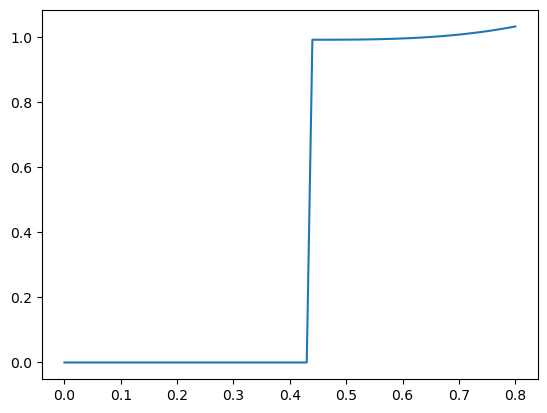

In [18]:
# Plot drop_func for AR.bins
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(AR.bins, drop_func(AR.bins * 100))
plt.show()

In [82]:
a = np.array([[[1, 1], [2, 1]], [[1, 1], [2, 1]]])
print(np.sum(np.sum(a, axis=0), axis=0))
normed_a = a / np.sum(a, axis=0)
totals = np.sum(normed_a, axis=0)
print(totals)
sum(abs(totals - 1) < 1e-6) == 0

[6 4]
[[1. 1.]
 [1. 1.]]


array([False, False])

In [20]:
# Testing get_bin_contribution_to_cpt
zbins = np.array([101, 102, 103, 104])

# shifted_x_bin = [101, 101]
# ValueError: Shifted X bin width should be non-zero

# shifted_x_bin = [101.5, 106]
# ValueError: A portion of the shifted X bin is outside the Z bins

shifted_x_bin = [101.5, 103.5]  # array([0.25, 0.5 , 0.25, 0.  ])
shifted_x_bin = [102, 103.5]  # array([0.        , 0.66666667, 0.33333333, 0.        ])
shifted_x_bin = [101.5, 104]  # array([0.2, 0.4, 0.4, 0. ])
shifted_x_bin = [102, 104]  # array([0. , 0.5, 0.5, 0. ])
shifted_x_bin = [101, 101]  # ValueError: Intersecting bin width should be non-zero
shifted_x_bin = [102, 102.1]  # array([0., 1., 0., 0.])
shifted_x_bin = [
    101.5,
    104.1,
]  # array([0.19230769, 0.38461538, 0.38461538, 0.03846154])
shifted_x_bin = [104.2, 104.3]  # array([0., 0., 0., 1.])

get_bin_contribution_to_cpt(shifted_x_bin, zbins, debug=True)

k=3, bin=[104;105], p=1.0 (=0.09999999999999432/0.09999999999999432)


array([0., 0., 0., 1.])

In [390]:
# Testing get_intersecting_bins_idx
zbins = np.array([101, 102, 103, 104])
zbinwidth = zbins[1] - zbins[0]
shifted_x_bin = [101.5, 103.5]  # 101, 103
shifted_x_bin = [102, 103.5]  # 102, 103
shifted_x_bin = [101.5, 104]  # 101, 103
shifted_x_bin = [102, 104]  # 102, 103
shifted_x_bin = [101, 101]  # ValueError: Intersecting bin width should be non-zero
shifted_x_bin = [102, 102.1]  # 102, 102
shifted_x_bin = [101.5, 104.1]  # 101, 104
shifted_x_bin = [104.2, 104.3]  # 104, 104
(k1, kn) = get_intersecting_bins_idx(shifted_x_bin, zbins, debug=True)

Idx from searchsorted func 4 , 4
Bins idx 3 , 3 corresponding to values 104 104
